# Manipulation des données de nuscenes avec panda

###  Nuscenes: https://github.com/nutonomy/nuscenes-devkit
### https://www.nuscenes.org/

NB: Les fonctions une fois finalisées seront dans utils, il est plus pratique actuellement de modifier directement sur le notebook

In [1]:
%matplotlib inline

from nuscenes.nuscenes import NuScenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\Alexandre\anaconda3\envs\nu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# data/sets/nuscenes
# D:\Utilisateurs\Alexandre\Repertoire_D\nuscenes\v1 0-trainval01

#nusc = NuScenes(version='v1.0-mini', dataroot='../data/sets/nuscenes')
nusc = NuScenes(version='v1.0-trainval', dataroot='D:/Utilisateurs/Alexandre/Repertoire_D/nuscenes/v1.0-trainval01')

nusc_can = NuScenesCanBus(dataroot='../data/sets/nuscenes')



Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 47.3 seconds.
Reverse indexing ...
Done reverse indexing in 8.3 seconds.


In [3]:
# nusc.list_scenes()

In [4]:
scene_name = 'scene-0061'
dic_scene = nusc_can.get_messages(scene_name,'vehicle_monitor')
#print(test)
features = ["vehicle_speed","steering","throttle","left_signal","right_signal"]
df_scene = pd.DataFrame.from_dict(dic_scene)[features]
print(df_scene)


    vehicle_speed  steering  throttle  left_signal  right_signal
0           31.44       3.0         0            0             0
1           30.73       3.5         0            1             0
2           29.45       3.6         0            1             0
3           28.09       3.6         0            0             0
4           27.07       3.5         0            0             0
5           26.25       3.6         0            1             0
6           25.35       4.0         0            0             0
7           24.51       4.7         0            0             0
8           23.58       6.5         0            1             0
9           22.69      12.6         0            1             0
10          21.89      23.8         0            0             0
11          21.20      34.4         0            0             0
12          20.25      45.8         0            1             0
13          19.34      69.8         0            1             0
14          18.33      87

In [5]:
scene_name = 'scene-0068'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')

## Premier test: essayer d'apprendre quand mettre le clignotant 
On va faire un essai pour prendre en main le dataset, avec seulement la vitesse, l'accélération et l'inclinaison du volant. Je ne pense pas qu'il soit possible de prévoir quand mettre un clignotant, il manque certaines informations (trajectoire notamment)

### 1/ Prétraitement des données

In [6]:
# Pour utiliser seulement nusc_can 
# (evite de charger nusc scene qui est plus lourd et ne sert actuellement qu'à prendre la liste des scenes)
# A faire 
def list_scene():
    pass

In [7]:
all_scene = [ s["name"] for s in nusc.scene ]
#print(all_scene)

In [8]:
# Mets des 1 tout le temps pour le clignotant au lieu d'une alternance par défaut
def fill_signal(df,signal):
    i = 0
    index = df.columns.get_loc(signal)
    while df[signal][i] != 1:
        i += 1
    while i  < len(df) and sum(df[signal][i:i+4]) >= 1:
        df.iat[i,index] = 1
        i += 1
    return df

In [9]:
#Ajoute une nouvelle colonne où les valeurs sont: 0(rien), 1(clignotant gauche), 2(clignotant droit)
#Plus pratique que "fill_signal" car on aura une seul colonne Y pour l'apprentissage
def add_signal_column(df,signal):
    i = 0
    tab = []
    while df[signal][i] != 1:
        tab += [0]
        i += 1
    while i  < len(df) and sum(df[signal][i:i+4]) >= 1:
        if signal == "right_signal":
            tab += [2]
        else:
            tab += [1]
        i += 1
    while i < len(df):
        tab += [0]
        i += 1
    df["signal"] = tab
    return df

In [10]:
blackint = nusc_can.can_blacklist
blacklist = [ "scene-0"+ str(i) for i in blackint]
print(blacklist)
print( "%s" in all_scene)

['scene-0161', 'scene-0162', 'scene-0163', 'scene-0164', 'scene-0165', 'scene-0166', 'scene-0167', 'scene-0168', 'scene-0170', 'scene-0171', 'scene-0172', 'scene-0173', 'scene-0174', 'scene-0175', 'scene-0176', 'scene-0309', 'scene-0310', 'scene-0311', 'scene-0312', 'scene-0313', 'scene-0314']
False


In [11]:
tab = []
for s in all_scene:
    if s not in blacklist and s not in ["scene-0419","scene-0420"] :
        dic_scene = nusc_can.get_messages(s,'vehicle_monitor')
        features = ["vehicle_speed","steering","throttle","left_signal","right_signal"]
        df_scene = pd.DataFrame.from_dict(dic_scene)[features]
        if df_scene["left_signal"].any():
            #df_scene = fill_signal(df_scene,"left_signal")
            new_df = add_signal_column(df_scene,"left_signal")
            #print(new_df)
        if df_scene["right_signal"].any():
            #df_scene = fill_signal(df_scene,"right_signal")
            new_df = add_signal_column(df_scene,"right_signal")
            #print(new_df)
        tab += [new_df]
    
df_total = pd.concat(tab)
print(len(all_scene))
print(df_total)
print(df_total.describe())

850
    vehicle_speed  steering  throttle  left_signal  right_signal  signal
0           14.74     191.9        55            0             0       0
1           14.63     206.4       125            0             0       0
2           15.19     206.3       158            1             0       0
3           16.10     192.3       182            1             0       0
4           17.24     120.1       202            0             0       0
..            ...       ...       ...          ...           ...     ...
35          39.21       2.1         0            0             1       2
36          36.06       3.1         0            0             0       2
37          32.50       2.4         0            0             0       2
38          29.00       1.3         0            0             1       2
39          25.50      -5.3         0            0             1       2

[33123 rows x 6 columns]
       vehicle_speed      steering      throttle   left_signal  right_signal  \
count   33123.

In [12]:
df_total.corr()

,vehicle_speed,steering,throttle,left_signal,right_signal,signal
vehicle_speed,1.000000,0.036777,0.240233,-0.161973,-0.189532,-0.399030
steering,0.036777,1.000000,-0.016328,0.251038,-0.235810,-0.228922
throttle,0.240233,-0.016328,1.000000,-0.083612,-0.085723,-0.181831
left_signal,-0.161973,0.251038,-0.083612,1.000000,-0.097808,0.041057
right_signal,-0.189532,-0.235810,-0.085723,-0.097808,1.000000,0.598528
signal,-0.399030,-0.228922,-0.181831,0.041057,0.598528,1.000000


### 2/ Apprentissage

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import svm, neighbors
from sklearn.ensemble import RandomForestClassifier
import random

In [14]:
features = ["vehicle_speed","steering","throttle"]
X = df_total[features]
y = df_total["signal"]
print(len(X)/20)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)

1656.15


#### 2/1/ K plus proches voisins et SVM sur une seule variable signal a 3 valeurs

In [15]:
model = neighbors.KNeighborsClassifier()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))

model2 = RandomForestClassifier(n_estimators=100,random_state = 42)
model2.fit(X_train,y_train)
model2.score(X_test,y_test)

0.7969811320754717


0.872754716981132

0.80 avec les 1000 scènes (can bus), c'est pas mal pour un modèle basique, on peut améliorer ça.
0.87 avec une forêt aléatoire, c'est encore mieux.
Mais le score reflète-t-il la vérité? Peut-être que dans la majorité de scènes dans le jeu de test le clignotant n'est pas utilisé et donc le score peut-être boosté? Vérifions ça. 

#### 2/2 Vérification du modèle

Matrice de confusion:

In [16]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,model.predict(X_test)))
print(confusion_matrix(y_test,model2.predict(X_test)))


[[3402  210  338]
 [ 288  549   63]
 [ 385   61 1329]]
[[3626  145  179]
 [ 169  688   43]
 [ 257   50 1468]]


Résultat de la matrice de confusion sur le jeu de test (170 scènes, 6625 échantillons) avec k voisins (gauche) et une forêt aléatoire (droite):
- [3402,  210,  338]-----[3626  145  179]
- [ 288,  549,   63]--------[169  688   43] 
- [ 385,   61, 1329]------[ 257   50 1468]

K voisins:
Résultats assez mitigés le taux de d'erreur pour le clignotant gauche est de 0.5 et du clignotant droit 0.25.

Forêt aléatoire:
Résultats plutôt bon, taux d'erreur pour le clignotant gauche est de 0.30 et du clignotant droit 0.15.

J'obtiens des résultats quasi-identique en changeant l'attribution des valeurs dans la colonne signal (clignotant gauche = 2 au lieu de 1). 
On peut par ailleurs noter qu'il y a un double des cas où le clignotant droite est activé par rapport au clignotant gauche, cela peut être l'une des raisons qui explique la différence de score.

## Deuxième test: anticiper la vitesse avec un véhicule en face

Principe de base (idée): 
    - le système de pilotage envoie les postions gps à suivre, la vitesse et l'angle recommandés à l'algorithme de gestion
    - l'algorithme de gestion en fonction de la situation va envoyer sur un modèle pour donner une nouvelle valeur de la vitesse et de l'angle par rapport à l'environnement
    - plusieurs modèles, mais en premier un basique : s'il y a personne en face on change rien, sinon calcul de la nouvelle vitesse par rapport au véhicule devant.

Pour cela, il nous faut plusieurs données pour ce modèle:
    - position, vitesse, orientation du véhicule égo (nous) et du véhicule en face
    - à compléter?


### 1/ Recherche de ces données

Prenons une scene où on suit une voiture, la scène 61. Cherchons l'instance de la voiture....

In [17]:
scene_test = nusc.scene[58] # 58 avec le dataset normal #0 avec le minidataset
scene_test

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [18]:
sample = nusc.get('sample',scene_test['last_sample_token'])
ann = sample['anns'][1]
ann_meta = nusc.get('sample_annotation', ann)
#nusc.list_sample(sample['token'])

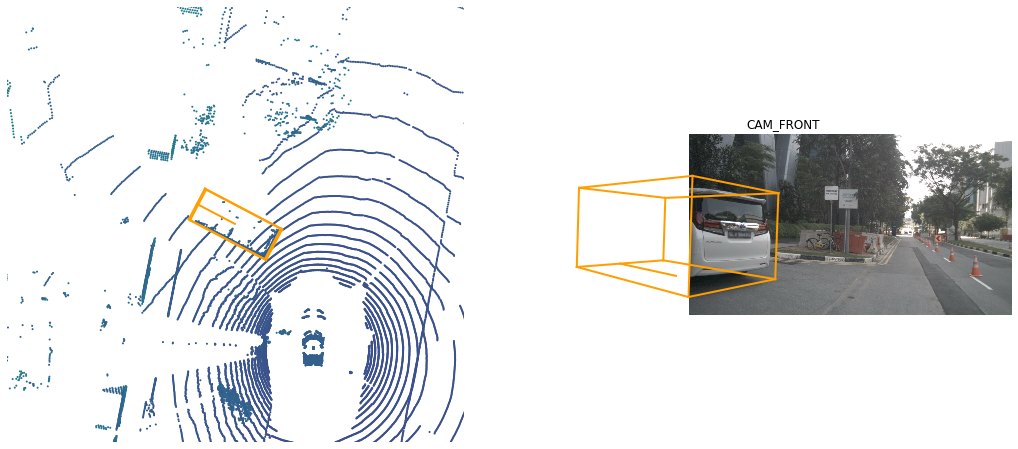

In [19]:
for at in sample['anns']:
    meta_data = nusc.get('sample_annotation',at)
    if meta_data['category_name'] == 'vehicle.car': 
        #print(meta_data)
        #print(nusc.get('instance', meta_data['instance_token']))
        #print("\n")
    
        #print(meta_data)
        pass
nusc.render_annotation("bc3180b07f8e4a728f504ded654df56f")
#bc3180b07f8e4a728f504ded654df56f

Token de l'instance de la voiture que l'on suit: c1958768d48640948f6053d04cffd35b

Maintenant, comparons la position de cette voiture à la notre. `field2token` permet d'accéder à la liste de tout les enregistrements d'une scene.

In [20]:
meta_data

{'token': '1ae79db45dd44f238c0af4009a5b1af6',
 'sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'instance_token': 'e045fa4da9e64d759fb780b20c707b3e',
 'visibility_token': '4',
 'attribute_tokens': [],
 'translation': [453.386, 1088.271, 0.495],
 'size': [0.582, 0.578, 0.844],
 'rotation': [0.2152466821173414, 0.0, 0.0, 0.9765597093048004],
 'prev': '06615b130d4a4f949231a857952783ac',
 'next': '',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'movable_object.trafficcone'}

In [21]:
ann_tokens = set(nusc.field2token('sample_annotation','instance_token',"c1958768d48640948f6053d04cffd35b"))
def print_pos_rot(pos,rot):
    print("{:04.2f} {:04.2f} {:04.2f}".format(pos[0],pos[1],pos[2]))
    print("{:04.2f} {:04.2f} {:04.2f}".format(rot[0],rot[1],rot[2]))

ego_pos = []
voiture_pos = []
ego_rot = []
voiture_rot = []
for at in ann_tokens:
    meta_data = nusc.get('sample_annotation',at)
    sample = nusc.get('sample',meta_data['sample_token'])
    timestamp = sample['timestamp']
    lidar = nusc.get('sample_data',sample['data']['LIDAR_TOP'])
    ego_token = lidar['ego_pose_token']
    ego = nusc.get('ego_pose',ego_token)
    #print_pos_rot(ego['translation'],ego['rotation'])
    #nt_pos_rot(meta_data['translation'],meta_data['rotation'])
    #print(meta_data['rotation'])
    ego_pos += [ego['translation']]
    ego_rot += [ego['rotation']]
    voiture_pos += [meta_data['translation']]
    voiture_rot += [meta_data['rotation']]    

#print(nusc.ego_pose[:300])
print(nusc.ego_pose[0])
len(nusc.ego_pose)

{'token': 'bddd80ae33ec4e32b27fdb3c1160a30e', 'timestamp': 1531883530440378, 'rotation': [-0.7504501527141022, -0.0076295847961364415, 0.00847103369020136, -0.6608287216181199], 'translation': [1010.1273947164545, 610.7727090350685, 0.0]}


2631083

Maintenant qu'on a les données de position de notre véhicule et celui d'en face, on peut essayer de visualiser sur la map ce qu'il en est pour pouvoir déterminer une formule/ fonction pour savoir si une voiture est en face de nous (sur la même voie serait l'idéal.
Problème, la rotation est en écriture quaternion (je ne sais pas comment manipuler), donc en attendant je vais essayer de détecter le véhicule en face par rapport à s'il est détecté par la caméra frontale puis en calculant la distance.


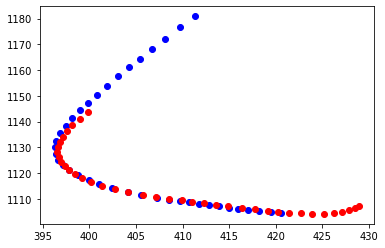

In [22]:
df_ego_pos = pd.DataFrame(ego_pos,columns=["x","y","z"])
#print(ego_rot)
#df_ego_rot = pd.DataFrame(ego_rot,columns=["x","y","z"])
df_voiture_pos = pd.DataFrame(voiture_pos,columns=["x","y","z"])
#df_voiture_rot = pd.DataFrame(voiture_rot,columns=["x","y","z"])
plt.plot(df_ego_pos["x"],df_ego_pos["y"],'bo')
plt.plot(df_voiture_pos["x"],df_voiture_pos["y"],'ro')


### 2/ Pretraitement sur les données
En regardant le code du sdk j'ai trouvé un bout de code utile qui me permet de savoir quel caméra a détecté l'annotation. Pour faire simple, je vais considérer (actuellement, cela va peut-être changer), qu'une voiture est en face de la notre si elle est détectée seulement par la caméra frontale et qu'elle respecte une certaine distance. Je vais maintenant regrouper toute ces données où on a une voiture en face nous.

`get_sample_data` renvoie plusieurs informations dont une liste de boxe de la caméra, si on lui passe un token en paramètre, il renvoie une seul boxe si l'instance est capturé par la caméra, rien sinon.

On peut maintenant créer le dataframe contenant toutes les informations: vitesse,distance,timestamp,accélération, token....
Voir `vehicle_data.csv`

In [23]:
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility

# renvoie vrai et un un tableau rempli si l'instance est en face d'ego et ego ne tourne pas trop
def find_vehicle_in_front(instance_token):
    instance = nusc.get('instance',instance_token)
    last_token = instance["last_annotation_token"]
    curr_token = instance["first_annotation_token"]
    rows_list = []
    i = 0
    
    ann = nusc.get('sample_annotation',instance["first_annotation_token"])
    sample = nusc.get('sample',ann['sample_token'])
    scene = nusc.get('scene',sample['scene_token'])
    dict_scene = nusc_can.get_messages(scene['name'],'vehicle_monitor') 
    taille = len(dict_scene)
    # Pour chaque enregistrement de l'annoation on ajoute une ligne avec les elements
    while curr_token != last_token:
        curr_ann = nusc.get('sample_annotation',curr_token)
        curr_sample = nusc.get('sample',curr_ann['sample_token'])        
        cams_check = []
        # (abs(dict_scene[i]['utime'] - curr_sample['timestamp']) > 250000 ) and
        while i < taille -1 and   (dict_scene[i]['utime'] + 250000 < curr_sample['timestamp']):
            #print("avance: ",i,curr_sample['timestamp']-1532402900000000," ",dict_scene[i]['utime']-1532402900000000)
            i += 1
        #print(curr_sample['timestamp'] - 1532402900000000,dict_scene[i]['utime'] - 1532402900000000  )  
        # récupérer les caméras qui ont vu l'annotation
        _, boxes, _ = nusc.get_sample_data(curr_sample['data']['CAM_FRONT'], box_vis_level=BoxVisibility.ANY,
                                                selected_anntokens=[curr_token])
        #and abs(dict_scene[i]['steering']) < 100
        if len(boxes) > 0:
            #calcul distance entre ego et le vehicule
            lidar = nusc.get('sample_data',curr_sample['data']['LIDAR_TOP'])
            ego_pos = nusc.get('ego_pose',lidar['ego_pose_token'])
            dist = np.linalg.norm(np.array(ego_pos['translation']) - np.array(curr_ann['translation']))
            dic = {'scene':scene['name'],'timestamp':curr_sample['timestamp'],'utime':dict_scene[i]['utime'],'inst_token':instance_token,
                   'ann_token':curr_token,'distance':round(dist,3),'steering':round(dict_scene[i]['steering'],3),'ego_speed':round(dict_scene[i]['vehicle_speed'],3),'throttle':dict_scene[i]['throttle'],
                   'brake':dict_scene[i]['brake'],'future_throttle':dict_scene[i+1]['throttle'],'future_brake':dict_scene[i+1]['brake']}
            rows_list += [dic]
                
        curr_token = curr_ann['next']   
        if i < taille - 2:
            i += 1
    #print(len(rows_list),len(dict_scene))
    return len(rows_list)!=0,rows_list

# renvoie un tableau rempli pour toute la scene avec les données du véhicule
def vehicle_info(scene):
    #sample = nusc.get('sample',scene['first_sample_token'])
    curr_token = scene['first_sample_token']
    rows_list = []
    last_token = scene['last_sample_token']
    i = 0

    dict_scene = nusc_can.get_messages(scene['name'],'vehicle_monitor') 
    taille = len(dict_scene)
    
    # Pour chaque enregistrement de la scene on ajoute une ligne avec les elements
    while curr_token != last_token:
        curr_sample = nusc.get('sample',curr_token)        
        while i < taille -2 and  (dict_scene[i]['utime'] + 250000 < curr_sample['timestamp']):
            i += 1
        #print(curr_sample['timestamp'] - 1532402900000000,dict_scene[i]['utime'] - 1532402900000000  )  
        dic = {'scene':scene['name'],'timestamp':curr_sample['timestamp'],'utime':dict_scene[i]['utime'],'inst_token':"vehicle_info",
               'ann_token':curr_token,'distance':-1,'steering':round(dict_scene[i]['steering'],3),'ego_speed':round(dict_scene[i]['vehicle_speed'],3),'throttle':dict_scene[i]['throttle'],
              'brake':dict_scene[i]['brake'],'future_throttle':dict_scene[i+1]['throttle'],'future_brake':dict_scene[i+1]['brake']}
        rows_list += [dic]
        curr_token = curr_sample['next']   
        if i < taille - 2:
            i += 1
    #print(len(rows_list),len(dict_scene))
    return rows_list
_ ,dic = find_vehicle_in_front("c1958768d48640948f6053d04cffd35b")
#print(dic)
df = pd.DataFrame.from_dict(dic).sort_values(by='timestamp').reset_index(drop=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,scene,timestamp,utime,inst_token,ann_token,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake
0,scene-0061,1532402927647951,1532402928127800,c1958768d48640948f6053d04cffd35b,49f76277d07541c5a584aa14c9d28754,39.038,3.0,31.44,0,0,0,0
1,scene-0061,1532402928147847,1532402928627159,c1958768d48640948f6053d04cffd35b,ae589a5a2bdb4813ae8021cd51b7e6eb,37.142,3.5,30.73,0,0,0,0
2,scene-0061,1532402928698048,1532402929127810,c1958768d48640948f6053d04cffd35b,e7a2133afb9c4c9b834225cc959d475a,34.983,3.6,29.45,0,0,0,0
3,scene-0061,1532402929197353,1532402929627057,c1958768d48640948f6053d04cffd35b,5a390e5c3f6249bb9f99c9be52614dd2,33.171,3.6,28.09,0,0,0,0
4,scene-0061,1532402929697797,1532402930127656,c1958768d48640948f6053d04cffd35b,0e5ab4ede0ad4cafaee8de500415e29a,31.421,3.5,27.07,0,0,0,0
5,scene-0061,1532402930152601,1532402930627445,c1958768d48640948f6053d04cffd35b,4a8dd530b1144dd1b8217dbe74b60e63,29.863,3.6,26.25,0,0,0,0
6,scene-0061,1532402930648325,1532402931127168,c1958768d48640948f6053d04cffd35b,92a23fb25b98444e93afd004ca31cca2,28.063,4.0,25.35,0,0,0,0
7,scene-0061,1532402931198511,1532402931627135,c1958768d48640948f6053d04cffd35b,5e5e0db2bcf642d680865d7c88a62f76,26.240,4.7,24.51,0,0,0,0
8,scene-0061,1532402931697833,1532402932127384,c1958768d48640948f6053d04cffd35b,49e7210442be48f495c50e38a50abdbf,24.592,6.5,23.58,0,0,0,0
9,scene-0061,1532402932197715,1532402932626799,c1958768d48640948f6053d04cffd35b,bb4c6ddbf99a4f1c930d01efd0bbfcd3,23.037,12.6,22.69,0,0,0,0


In [24]:
blackint = nusc_can.can_blacklist
blacklist = [ "scene-0"+ str(i) for i in blackint]
# 1532402936198962 1532402936699359 1532402937198682

# Liste toutes les instances d'une scene
def get_instances_scene(scene):
    sample = nusc.get('sample',scene['first_sample_token'])
    list_instances = []
    while sample['token'] != scene['last_sample_token']:
        anns = sample['anns']
        for ann_token in anns:
            ann = nusc.get('sample_annotation',ann_token)
            instance = nusc.get('instance',ann['instance_token'])
            category = nusc.get('category',instance['category_token'])
            if not instance in list_instances and "vehicle" in category['name']:
                list_instances += [instance]
        sample = nusc.get('sample',sample['next'])
    return list_instances

# Renvoie un dataframe contenant les données de toutes les instances de la scene
def build_dataframe_for_one_scene(s,affichage):
    list_rows = vehicle_info(s)
    list_instances = get_instances_scene(s)
    for inst in list_instances:
        ok, res = find_vehicle_in_front(inst['token'])
        if affichage:
            print(len(res)," echantillons")   
        if ok:
            list_rows += res
    return pd.DataFrame.from_dict(list_rows).sort_values(by='timestamp').reset_index(drop=True)

# Explore chaque scene, puis chaque instance de cette scene qui est un vehicle en mouvement (devant)
# Cree un dataframe avec pour entree distance au vehicle, ego_vitesse, ego_accel, ego_brake 
# et vehicle_vitesse (pas mtn)
def build_dataframe_for_vehicle_in_front():
    scenes = nusc.scene[:10]
    list_rows = []
    first = True
    for s in scenes:
        if s['name'] not in blacklist and s['name']  not in ["scene-0003"]:
            if first:
                dataframe = build_dataframe_for_one_scene(s,False)
                first = False
            else:
                datatemp = build_dataframe_for_one_scene(s,False)
                dataframe = dataframe.append(datatemp,ignore_index=True)

    print(dataframe)
    print(dataframe.describe())
    return dataframe
    
#find_vehicle_in_front("c1958768d48640948f6053d04cffd35b")
# 15k ligne sans contrainte sur steering (100 scenes)
#df_vehicle = build_dataframe_for_vehicle_in_front()
#df_vehicle = df_vehicle.sort_values(by=['timestamp'])
#df_vehicle.to_csv(path_or_buf="vehicle_data.csv",index=False)
scene_name = 'scene-0061'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
scene = nusc.get('scene',my_scene_token)
#nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
df = build_dataframe_for_one_scene(scene,False)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
display(df)

,scene,timestamp,utime,inst_token,ann_token,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake
0,scene-0061,1532402927647951,1532402928127800,vehicle_info,ca9a282c9e77460f8360f564131a8af5,-1.000,3.0,31.44,0,0,0,0
1,scene-0061,1532402927647951,1532402928127800,a60047adc78a4b6895702e86b6d2fe88,b7cbc6d0e80e4dfda7164871ece6cb71,47.211,3.0,31.44,0,0,0,0
2,scene-0061,1532402927647951,1532402928127800,e3c5b72c12c34c85aac247734ad83bef,91cb8f15ed4444e99470d43515e50c1d,72.006,3.0,31.44,0,0,0,0
3,scene-0061,1532402927647951,1532402928127800,42641eb6adcb4f8f8def8ef129d9e843,a6f7d4bb60374f868144c5ba4431bf4c,72.259,3.0,31.44,0,0,0,0
4,scene-0061,1532402927647951,1532402928127800,85246a44cc6340509e3882e2ff088391,cda0a9085607438c9b1ea87f4360dd64,41.419,3.0,31.44,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
310,scene-0061,1532402945697148,1532402946627093,c1958768d48640948f6053d04cffd35b,cad8d5a3f7cc4c55bc44da68369f49da,9.779,155.8,7.50,0,6,0,2
311,scene-0061,1532402946297085,1532402946627093,vehicle_info,29e056fc277543c9bc42310b122c640e,-1.000,155.8,7.50,0,6,0,2
312,scene-0061,1532402946297085,1532402946627093,f0056532879643c69e4efc9d845782f0,93bbd23c226d4fbf8c2b6c58a24c61c5,15.955,155.8,7.50,0,6,0,2
313,scene-0061,1532402946297085,1532402946627093,c1958768d48640948f6053d04cffd35b,d02856dbe859476f9635f449d23aa211,9.219,155.8,7.50,0,6,0,2


On faisant une matrice de corrélation, on aperçoit que la distance entre les deux véhicules et un influencer par la vitesse principalement, le frein agit un peu dessus. De plus, la vitesse est trés corrélée avec le frein. L'accélération a un peu d'effet sur la vitesse, voir aucun sur la distance, cela est un peu étonnant.

In [25]:
df_vehicle.corr()

NameError: name 'df_vehicle' is not defined

### 3/ Apprentissage


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm, neighbors
from sklearn.ensemble import RandomForestClassifier
import random

features = ["distance","ego_speed","throttle","brake"]
X = df_vehicle[features]
y_throttle = df_vehicle["future_throttle"]
y_brake = df_vehicle["future_brake"]
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X,y_throttle, test_size = 0.2, random_state = 1)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X,y_brake, test_size = 0.2, random_state = 1)

In [ ]:
model_t = svm.SVR()
model_t.fit(Xt_train,yt_train)
print(model_t.score(Xt_test,yt_test))

model_b = svm.SVR()
model_b.fit(Xb_train,yb_train)
print(model_b.score(Xb_test,yb_test))


Scène intéressante pour prédire le frein: 14 
Scène avec piéton: 25,29,43

Il pourrait être intéressant de pouvoir afficher la scène avec les résultats de la prédiction

In [ ]:
scene_name = 'scene-0067'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
#nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')

In [ ]:
def sort_distance(dataframe):
    pass

In [30]:
import cv2
from typing import Tuple, List
import os.path as osp
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
import operator


def get_color(category_name: str) -> Tuple[int, int, int]:
    """
    Provides the default colors based on the category names.
    This method works for the general nuScenes categories, as well as the nuScenes detection categories.
    """
    if 'bicycle' in category_name or 'motorcycle' in category_name:
        return 255, 61, 99  # Red
    elif 'vehicle' in category_name or category_name in ['bus', 'car', 'construction_vehicle', 'trailer', 'truck']:
        return 255, 158, 0  # Orange
    elif 'pedestrian' in category_name:
        return 0, 0, 230  # Blue
    elif 'cone' in category_name or 'barrier' in category_name:
        return 0, 0, 0  # Black
    else:
        return 255, 0, 255  # Magenta
        
    
def render_scene_channel_with_predict(nusc,
                        scene_token: str, dataframe,
                        channel: str = 'CAM_FRONT',
                        freq: float = 10,
                        imsize: Tuple[float, float] = (960, 540),
                        out_path: str = None) -> None:
    """
    Renders a full scene for a particular camera channel.
    :param scene_token: Unique identifier of scene to render.
    :param channel: Channel to render.
    :param freq: Display frequency (Hz).
    :param imsize: Size of image to render. The larger the slower this will run.
    :param out_path: Optional path to write a video file of the rendered frames.
    """
    valid_channels = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
                        'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']

    assert imsize[0] / imsize[1] == 16 / 9, "Aspect ratio should be 16/9."
    assert channel in valid_channels, 'Input channel {} not valid.'.format(channel)

    if out_path is not None:
        assert osp.splitext(out_path)[-1] == '.avi'

    # Get records from DB
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data'][channel])

    # Open CV init
    name = '{}: {} (Space to pause, ESC to exit)'.format(scene_rec['name'], channel)
    cv2.namedWindow(name)
    cv2.moveWindow(name, 0, 0)

    if out_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(out_path, fourcc, freq, imsize)
    else:
        out = None

    # parametres pour cv2
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,500)
    fontScale              = 1
    fontColor              = (255,255,255)
    color              = (255,0,0)

    lineType               = 2
    pas = (0,50)
    
    # parametres pour afficher infos
    i = 0
    taille = dataframe.shape[0]
    scene_token = nusc.field2token('scene', 'name', dataframe.at[0,'scene'])[0]
    scene = nusc.get('scene',scene_token)
    sample = nusc.get('sample',scene['first_sample_token'])
    df_curr = dataframe[dataframe['timestamp'] == sample['timestamp']]
    df_curr = df_curr.sort_values(by='distance').reset_index(drop=True)
    print(df_curr)
    has_more_frames = True
    while has_more_frames:
        

        # Get data from DB
        impath, boxes, camera_intrinsic = nusc.get_sample_data(sd_rec['token'],
                                                                    box_vis_level=BoxVisibility.ANY)

        # Load and render
        if not osp.exists(impath):
            raise Exception('Error: Missing image %s' % impath)
        im = cv2.imread(impath)
        for box in boxes:
            c = get_color(box.name)
            box.render_cv2(im, view=camera_intrinsic, normalize=True, colors=(c, c, c))

        # Affichage informations
        
        if sample['token'] != scene['last_sample_token']:
            if not df_curr.empty:
                #print("passe")
                
                cv2.putText(im, 'Vitesse:'+ str(df_curr.iat[0,7]), 
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale, 
                    fontColor,
                    lineType)
                cv2.putText(im, 'Angle volant:'+ str(df_curr.iat[0,6]), 
                    tuple(map(operator.add, bottomLeftCornerOfText,(0,50))), 
                    font, 
                    fontScale, 
                    fontColor,
                    lineType)
                cv2.putText(im, 'Acceleration:'+ str(df_curr.iat[0,8]), 
                    tuple(map(operator.add, bottomLeftCornerOfText,(0,100))), 
                    font, 
                    fontScale, 
                    fontColor,
                    lineType)
                
                cv2.putText(im, 'Frein:'+ str(df_curr.iat[0,9]), 
                    tuple(map(operator.add, bottomLeftCornerOfText,(0,150))), 
                    font, 
                    fontScale, 
                    fontColor,
                    lineType)
                cv2.putText(im, 'Acceleration (Pred):'+ str(df_curr.iat[0,10]), 
                    tuple(map(operator.add, bottomLeftCornerOfText,(0,200))), 
                    font, 
                    fontScale, 
                    fontColor,
                    lineType)
                
                cv2.putText(im, 'Frein (Pred):'+ str(df_curr.iat[0,11]), 
                    tuple(map(operator.add, bottomLeftCornerOfText,(0,250))), 
                    font, 
                    fontScale, 
                    fontColor,
                    lineType)
                
                if df_curr.shape[0] > 1:
                    cv2.putText(im, 'Distance:'+ str(df_curr.iat[1,5]), 
                        tuple(map(operator.add, bottomLeftCornerOfText,(0,300))), 
                        font, 
                        fontScale, 
                        color,
                        lineType)
            else:
                print(sample['timestamp'])
            if i%6 == 0 and i != 0:
                sample = nusc.get('sample',sample['next'])
                df_curr = dataframe[dataframe['timestamp'] == sample['timestamp']]
                df_curr = df_curr.sort_values(by='distance').reset_index(drop=True)
                print("changement")
        else:
            print("fin des données ",i)

            
        # Render
        im = cv2.resize(im, imsize)
        cv2.imshow(name, im)
        if out_path is not None:
            out.write(im)

        key = cv2.waitKey(10)  # Images stored at approx 10 Hz, so wait 10 ms.
        if key == 32:  # If space is pressed, pause.
            key = cv2.waitKey()

        if key == 27:  # if ESC is pressed, exit
            cv2.destroyAllWindows()
            break

        if not sd_rec['next'] == "":
            sd_rec = nusc.get('sample_data', sd_rec['next'])
        else:
            has_more_frames = False
        i += 1
    print("nombre de frame: ",i)
    cv2.destroyAllWindows()
    if out_path is not None:
        out.release()


In [58]:
scene_name = 'scene-0014'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
scene = nusc.get('scene',my_scene_token)
#nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
df = build_dataframe_for_one_scene(scene,False)
print(df)
#df.to_csv(scene_name+".csv")

render_scene_channel_with_predict(nusc,my_scene_token,df, 'CAM_FRONT')
df.iat[0,0]
df.shape


         scene         timestamp             utime  \
0   scene-0022  1531885998548873  1531885998881201   
1   scene-0022  1531885999048784  1531885999380687   
2   scene-0022  1531885999548065  1531885999880333   
3   scene-0022  1531886000048491  1531886000380797   
4   scene-0022  1531886000548367  1531886000881394   
..         ...               ...               ...   
79  scene-0022  1531886016898293  1531886017380294   
80  scene-0022  1531886016898293  1531886016880461   
81  scene-0022  1531886017448488  1531886017880488   
82  scene-0022  1531886017448488  1531886017380294   
83  scene-0022  1531886017448488  1531886017380294   

                          inst_token                         ann_token  \
0                       vehicle_info  1247776e94cd4c2999df4d8cf07b43ee   
1                       vehicle_info  0ca7e4ab1f17416b9b40a867becc746e   
2                       vehicle_info  bf0f869608744492b861152fe1a00da4   
3                       vehicle_info  d7f280ad9f5648cbb

(84, 12)

67 piéton traverse,
6 camion au milieu (pas mal)
9,10 il se passe rien
14 arret puis démarrage car bus avance

Prédire trajectoire en entier...

In [59]:
#nusc.list_scenes()